# テスト的に一度実際のbotで実装を試してみるノートブック，ごちゃごちゃしそうなので注意

In [1]:
import chainer
import chainer.functions as F
import chainer.links as L
import chainerrl
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn


import warnings
warnings.simplefilter('ignore',  category=pd.errors.PerformanceWarning)#解決できない警告は無視

ModuleNotFoundError: No module named 'chainer'

In [2]:
place_name='asiya'

result_filepath="../boatracer_BOT_making/bot_database/{place_name}/{place_name}_train/train_{place_name}.csv".format(place_name=place_name)#作成したデータの書き込み先#使用するデータの読み込み
sample_race_df=pd.read_csv(result_filepath)
sample_race_df=sample_race_df.drop(["Unnamed: 0"],axis=1)
sample_race_df.head()

,date,result_com,money,number_race,racer_1_ID,racer_2_ID,racer_3_ID,racer_4_ID,racer_5_ID,racer_6_ID,...,racer_2_bo,racer_2_mo,racer_3_bo,racer_3_mo,racer_4_bo,racer_4_mo,racer_5_bo,racer_5_mo,racer_6_bo,racer_6_mo
0,2012-04-03,6,1160.0,1,3959,3793,4196,3326,4583,4037,...,33.0,40.0,56.0,67.0,59.0,45.0,60.0,42.0,29.0,47.0
1,2012-04-03,3,2960.0,2,3251,4268,4158,4305,3352,4097,...,39.0,63.0,31.0,34.0,15.0,73.0,2.0,56.0,1.0,52.0
2,2012-04-03,44,21490.0,3,3662,4026,3564,3875,4096,3925,...,27.0,74.0,52.0,62.0,7.0,70.0,14.0,55.0,48.0,66.0
3,2012-04-03,62,5100.0,4,4266,3741,3788,3527,4321,4363,...,28.0,32.0,5.0,57.0,16.0,69.0,23.0,51.0,38.0,58.0
4,2012-04-03,25,1980.0,5,4112,4296,3326,4327,2763,4573,...,11.0,33.0,59.0,45.0,35.0,38.0,24.0,49.0,53.0,75.0


# 関数

In [3]:
def trans_date_type(df):
    df['date']=pd.to_datetime(df['date'])#日付が文字列なのでdateを日付型に変換
    #df['year']=df['date'].dt.year
    #df=df.drop('date',axis=1)
    return df

def data_making(df):#クラスタリングなし、ボート、艇番号無し
    warnings.simplefilter('ignore',  category=pd.errors.PerformanceWarning)#解決できない警告は無視
    result_df=df
    result_df=result_df.drop(["racer_1_ID","racer_2_ID","racer_3_ID","racer_4_ID","racer_5_ID","racer_6_ID",],axis=1)#IDはいらないので削除
    result_df=result_df.replace(0.0000,{"racer_1_ave_st_time":0.22})#新人のave_st_timeを0.22に
    result_df=result_df.replace(0.0000,{"racer_2_ave_st_time":0.22})
    result_df=result_df.replace(0.0000,{"racer_3_ave_st_time":0.22})
    result_df=result_df.replace(0.0000,{"racer_4_ave_st_time":0.22})
    result_df=result_df.replace(0.0000,{"racer_5_ave_st_time":0.22})
    result_df=result_df.replace(0.0000,{"racer_6_ave_st_time":0.22})
    result_df=result_df.replace(0.0000,{"racer_1_doub_win":0.02})#新人の着に絡む確率ave_st_timeを0.02に(新人の半期の偏差から導出)
    result_df=result_df.replace(0.0000,{"racer_2_doub_win":0.02})
    result_df=result_df.replace(0.0000,{"racer_3_doub_win":0.02})
    result_df=result_df.replace(0.0000,{"racer_4_doub_win":0.02})
    result_df=result_df.replace(0.0000,{"racer_5_doub_win":0.02})
    result_df=result_df.replace(0.0000,{"racer_6_doub_win":0.02})
    #ダミー変数化
    result_df_dummie=result_df
    race_dummie_df=pd.get_dummies(result_df_dummie['number_race'])#number_raceをダミー化
    for column, val in race_dummie_df.iteritems():
        result_df_dummie['race_{}'.format(int(column))]=val
    result_df_dummie=result_df_dummie.drop('number_race',axis=1)

    cols=list(result_df_dummie.columns)
    male_cols=[s for s in cols if 'male' in s]#性別を示すカラムを取り出す

    #===========================新規、性別の取り出し機能が良くなかったため作り直す
    empty_arr=[0]*len(result_df_dummie)
    for col in male_cols:
        for number in np.arange(0,2,1):
              result_df_dummie['{}_{}'.format(col,int(number))]=empty_arr
        male_dummie_df=pd.get_dummies(result_df_dummie[col])#性別をダミー化
        for column, val in male_dummie_df.iteritems():
              result_df_dummie['{}_{}'.format(col,int(column))]=val
        result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1)

    cols=list(result_df_dummie.columns)
    moter_cols=[s for s in cols if '_mo' in s]#モーター番号を示すカラムを取り出す
    boat_cols=[s for s in cols if '_bo' in s]#ボート番号を示すカラムを取り出す
    #boat、moterの情報は使わない、
    numbers=np.arange(1, 100, 1)
    empty_arr=[0]*len(result_df_dummie)
    for col in moter_cols:
        result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1).copy()
    for col in boat_cols:
        result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1).copy()
    clustar_target_df=result_df_dummie
    clustaring_df=clustar_target_df
    model_df=clustaring_df
    model_df=trans_date_type(model_df)
    return model_df


# boatraceでの環境の定義（cartpoleを参考に）

# 出力を1～28の確率分布とし，それを係数として購買を行う＝確率分布で出力するやり方がわからない，最もらしい行動を一つピックアップされてしまう

In [10]:
class BoatraceEnv:
#class BoatraceEnv(必要であればここに購買金額の係数等を書いてあげる):
    def __init__(self,race_df,cash,bet_coefficient=10000,end_th_cash_magni=0.5):#メンバ等の定義
        
        self.st_cash = cash#初めに持っている所持金
        self.cash = cash#所持金（初めは上のものと同じ値が入るが，こちらの変数はゲームが進んでいくと更新されていく）
        self.end_th_cash = cash*end_th_cash_magni#所持金がいくらを下回ったらゲームオーバーか決めるための閾値金額(end_th_cashで何パーセントを下回ったらアウトかを指定)
        self.bet_coefficient = bet_coefficient#購買時を想定して定数倍する係数
        self.random_state = 7#何かと生成をするときに使うためのシード値
        self.race_df=race_df#全部のレース情報のまとめdfを格納
        
        #self.race_ID=0#どこのレースを抜き出すかどうかの番号付け
        self.race_ID=0#どこのレースを抜き出すかどうかの番号付け(インデックス参照で抜き出す)
        self.total_gain = None#現時点と開始時を比較した時の利益率(reset()で要リセット)
        self.total_use = 0#現時点までの総使用金額(reset()で要リセット)
        self.total_get = 0#現時点までの総獲得金額(reset()で要リセット)
        self.state = None#1レースあたりのデータ格納用のメンバ
        self.steps_beyond_done = None
        
        #Q関数定義時関連の処理
        self.n_action=28#行動の種類(28通りのcomを購買対象とする)
        sample_df=self.race_df.copy()
        sample_df=sample_df.drop(['date',"result_com","money"],axis=1)
        self.obs_size=len(sample_df.columns)#予測に使う情報の次元数

#     def seed(self, seed=None):
#         self.np_random, seed = seeding.np_random(seed)
#         return [seed]
    def split_race_data(self,race_ID):#レースのID(インデックス)を渡して，レースの情報を学習時などに使いやすい形に切り分けるメソッド
        race_row=self.race_df.iloc[race_ID]#対象のレースを切り抜き(series型)
        result_com=race_row['result_com']
        return_money=race_row['money']
        racer_ID=race_row['money']
        race_date=race_row['date']
        race_data=race_row.drop(['date',"result_com","money"]).values
        race_data_label=race_row.drop(['date',"result_com","money"]).index
                                
        #race_data:選手情報やボート・モータ番号などの予測用データが入った配列
        #race_data_label:予測用データの役割を示す配列(pandasの列名（カラム）がこれに該当する)
        return result_com,return_money,race_data,race_data_label,race_date

    def step(self, action):#ステップ（ゲームの報酬計算と次の環境の取得）
        race_ID=self.race_ID
        result_com,return_money,race_data,race_data_label,race_date=self.split_race_data(self.race_ID)#いろいろ算出用にレースデータの抜き取り
        return_money_magni=return_money/100#配当金を倍率に変換
        #state = self.state
                                      
        #それに応じて購買行動を行う(1～28で購買を行う)
        #インデックス番号＋１が購買を行う番号と対応している（はず）
        total_use=sum(action)#使った金額の算出
        #total_use=sum(action)*self.bet_coefficient#使った金額の算出
        
        #当たったかどうかの判別と，リターンの算出
        race_use=0
        for label,pred in zip(np.arange(1, len(action)+1) ,action):#予測のラベル(com)と購買金額の倍率で一緒にfor分を回す
            race_use+=pred
            if label==result_com:#ラベルと結果が一致したら
                race_get=pred*return_money_magni#return_money_magni:配当の倍率(magnification)
                #get=pred*self.bet_coefficient*return_money_magni
            else:
                pass
        
        #収支計算()
        #race_gain=(race_get/race_use)#廃止，これだと０除算になる可能性が高い
        race_gain=race_get-race_use#割合でなく，実際の金額で計算．（まあ本番も利益額大きい方がうれしいし？？？）
        self.total_use+=race_use
        self.total_get+=race_get
        if (self.total_get!=0) and (self.total_get!=0):
            self.total_gain=((self.total_get/self.total_use)*100)-100#利益率を計算(減ってるとマイナスになる)
        else:
            self.total_gain=0
        before_cash=self.cash#購買行動を行う前の所持金を取っておく
        self.cash=self.cash-race_use#使用金額を引く
        self.cash=self.cash+race_get#配当金を足す
        diff_cash=self.cash-before_cash#購買を行う前と後の金額を比較(減ってるとマイナスになる)
        
        #報酬の決定
        reward=diff_cash#前のレースと比べてお金が増えたか減ったかをそのまま報酬とする
#         if diff_cash==0:
#             reward=-0.1*bet_coefficient#全く購買を行わないのにも罰則を与える
        
        #各種フラグの付与（ゲームが続くか続かないか）
        if self.cash<self.end_th_cash:#所持金が指定金額以上に減ったらゲームオーバー
            done=True
        else:
            done=False
            
        #次の観測（次のレース）の取り出し
        self.race_ID=self.race_ID+1#次の状態を抜き出すためにIDに1を足す
        if self.race_ID>(len(self.race_df)-1):#次の状態(レース)がなくなったら終了
            done=True
            self.state=None
            reward=None
        else:
            result_com_next,return_money_next,race_data_next,race_data_label_next,race_date_next=self.split_race_data(self.race_ID)
            
        #行動分析用の追加評価値
        #total_gain=(self.cash/self.st_cash)*100#現時点での利益率
        total_income=self.total_get-self.total_use#獲得とそうでないものの差から，今までの利益額を算出
        scores_dict={
            'total_gain':self.total_gain ,
            'total_income':total_income ,
            'total_get':self.total_get ,
            'total_use':self.total_use
        }
        return np.array(race_data_next), reward, done, scores_dict

    def reset(self):#環境の初期化用メソッド
        self.cash = self.st_cash#スタート時の所持金
        self.race_ID=0#どこのレースを抜き出すかどうかの番号付け(インデックス参照で抜き出す)
        self.total_gain = None#現時点と開始時を比較した時の利益率(reset()で要リセット)
        self.total_use = 0#現時点までの総使用金額(reset()で要リセット)
        self.total_get = 0#現時点までの総獲得金額(reset()で要リセット)
        self.state = None#1レースあたりのデータ格納用のメンバ
        self.steps_beyond_done = None
        
        #df内の初めのレースの取り出し
        result_com,return_money,race_data,race_data_label,race_date=self.split_race_data(self.race_ID)#いろいろ算出用にレースデータの抜き取り
        self.state =race_data
        
        return np.array(self.state)
    
    def random_action_func(self):#ランダムな行動を生成するための関数
        random_action=np.random.rand(28)#サイズ28のランダムな行動を生成する
        return random_action


# Q関数の定義
## 入力:学習データそのまま
## 出力:1～29(29は購買しない)




In [11]:

class QFunction(chainer.Chain):#chainer.Chain:link Lやfunction Fをまとめて管理するものらしい，親クラスとして提供されているためニューラルネットを定義する際はこれを継承させるらしい．

    def __init__(self, obs_size, n_actions, n_hidden_channels=100):
        super().__init__()
        #n_actions:行動の種類数
        #obs_size :入力データの次元数
        #l1,l2等々は層を表してる，l2が出力層
        with self.init_scope():
            self.l0 = L.Linear(obs_size, n_hidden_channels)#Lはchainer.linksです（インポート時にas　L　でインポートしてる）
            self.l1 = L.Linear(n_hidden_channels, n_hidden_channels)#Lはchainer.linksです（インポート時にas　L　でインポートしてる）
            self.l2 = L.Linear(n_hidden_channels, n_actions)#Lはchainer.linksです（インポート時にas　L　でインポートしてる）

    def __call__(self, x, test=False):
        """
        Args:
            x (ndarray or chainer.Variable): An observation
            test (bool): a flag indicating whether it is in test mode
            [翻訳]
            x（ndarrayまたはchainer.Variable）：観測値
            test（bool）：テストモードかどうかを示すフラグ
        """
        h = F.tanh(self.l0(x))#F は　chainer.functions
        h = F.tanh(self.l1(h))#F は　chainer.functions
        return chainerrl.action_value.DiscreteActionValue(self.l2(h))



# 試しに動かしてみる

#### envのテスト

In [6]:
place_name='asiya'
cash=100000#所持金

result_filepath="../boatracer_BOT_making/bot_database/{place_name}/{place_name}_train/train_{place_name}.csv".format(place_name=place_name)#作成したデータの書き込み先#使用するデータの読み込み
sample_race_df=pd.read_csv(result_filepath)
sample_race_df=sample_race_df.drop(["Unnamed: 0"],axis=1)
sample_race_df.head()
sample_race_df=data_making_mo_bo(sample_race_df)#前処理

asiya_env =BoatraceEnv(sample_race_df,cash)#環境の作成（クラス）
obs = asiya_env.reset()

test_action=[0,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0]#たくさん買ってるけどあたってない
#test_action=[0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]#一点買いであたった
#test_action=[1,2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]#あたってる
obs, r, done, info = asiya_env.step(test_action)
print('obs',obs)
print('r',r)
print('done',done)
print('info',info)

obs [4 46.0 0.45 ... 0 0 0]
r -8.0
done False
info {'total_gain': 0, 'total_income': -8.0, 'total_get': 0.0, 'total_use': 8}


## 定義

In [14]:
place_name='asiya'
#cash=100000#所持金
cash=100#所持金

result_filepath="../boatracer_BOT_making/bot_database/{place_name}/{place_name}_train/train_{place_name}.csv".format(place_name=place_name)#作成したデータの書き込み先#使用するデータの読み込み
sample_race_df=pd.read_csv(result_filepath)
sample_race_df=sample_race_df.drop(["Unnamed: 0"],axis=1)
sample_race_df.head()

asiya_env =BoatraceEnv(sample_race_df,cash)#環境の作成（クラス）

#Q関数の設定
obs_size = asiya_env.obs_size
n_actions = asiya_env.n_action
q_func = QFunction(obs_size, n_actions)
#q_func.to_gpu(0) ## GPUを使いたい人はこのコメントを外す

#最適化手法とパラメータ設定
optimizer = chainer.optimizers.Adam(eps=1e-2)
optimizer.setup(q_func) #設計したq関数の最適化にAdamを使う
gamma = 0.80#報酬の割引率.過去の結果をどのくらい重要視するか
explorer = chainerrl.explorers.ConstantEpsilonGreedy(#次の戦略を考えるときの方法
    epsilon=0.3, random_action_func=asiya_env.random_action_func)
replay_buffer = chainerrl.replay_buffer.ReplayBuffer(capacity = 10**6)#Replayを実行するかどうか
phi = lambda x:x.astype(np.float32, copy=False)##型の変換(chainerはfloat32型。float64は駄目)

agent = chainerrl.agents.DoubleDQN(
    q_func, optimizer, replay_buffer, gamma, explorer,
    replay_start_size=500, update_interval=1,
    target_update_interval=100, phi=phi)

In [20]:
n_actions

28

In [15]:
print(obs)
print(len(obs))#入力データ

[4 46.0 0.45 ... 0 0 0]
1236


## 学習

In [16]:
import time
n_episodes = 200
max_episode_len = 200
start = time.time()
for i in range(1, n_episodes + 1):
    v = asiya_env.reset()
    reward = 0
    done = False
    R = 0  # return (sum of rewards)
    t = 0  # time step
    while not done and t < max_episode_len:
        action = agent.act_and_train(obs, reward)
        obs, reward, done, _ = asiya_env.step(action)
        R += reward
        t += 1
    if i % 10 == 0:
        print('episode:', i,
              'R:', R,
              'statistics:', agent.get_statistics())
    agent.stop_episode_and_train(obs, reward, done)
print('Finished, elapsed time : {}'.format(time.time()-start))

TypeError: 'numpy.int32' object is not iterable

In [17]:
action

14

In [18]:
obs

array([1, 3959, 3793, 4196, 3326, 4583, 4037, 4, 1, 35.0, 0.541, 0.14, 2,
       1, 40.0, 0.287, 0.19, 2, 1, 30.0, 0.327, 0.19, 3, 1, 45.0, 0.421,
       0.16, 2, 1, 23.0, 0.252, 0.18, 3, 1, 34.0, 0.396, 0.19, 3.0, 43.0,
       33.0, 40.0, 56.0, 67.0, 59.0, 45.0, 60.0, 42.0, 29.0, 47.0],
      dtype=object)

# 会場ごと，comごとにターゲットを指定して，comごとの最適な買い方を学習する

In [4]:
class BoatraceComEnv:#comごとに一つの環境を設定する
#class BoatraceEnv(必要であればここに購買金額の係数等を書いてあげる):
    def split_race_data(self,race_ID):#レースのID(インデックス)を渡して，レースの情報を学習時などに使いやすい形に切り分けるメソッド
        race_row=self.trans_race_df.iloc[race_ID]#対象のレースを切り抜き(series型)
        result_com=race_row['result_com']
        return_money=race_row['money']
        racer_ID=race_row['money']
        race_date=race_row['date']
        race_data=race_row.drop(['date',"result_com","money"]).values
        race_data_label=race_row.drop(['date',"result_com","money"]).index
                                
        #race_data:選手情報やボート・モータ番号などの予測用データが入った配列
        #race_data_label:予測用データの役割を示す配列(pandasの列名（カラム）がこれに該当する)
        return result_com,return_money,race_data,race_data_label,race_date
    
    def split_race_data_tail(self,race_ID):#レースのID(インデックス)を渡して，レースの情報を学習時などに使いやすい形に切り分けるメソッド,後ろから抽出
        race_row=self.trans_race_df.iloc[-1*race_ID]#対象のレースを切り抜き(series型)
        result_com=race_row['result_com']
        return_money=race_row['money']
        racer_ID=race_row['money']
        race_date=race_row['date']
        race_data=race_row.drop(['date',"result_com","money"]).values
        race_data_label=race_row.drop(['date',"result_com","money"]).index
                                
        #race_data:選手情報やボート・モータ番号などの予測用データが入った配列
        #race_data_label:予測用データの役割を示す配列(pandasの列名（カラム）がこれに該当する)
        return result_com,return_money,race_data,race_data_label,race_date
    
    def trans_target_result_com_df(self):#target_comに応じてresult_comを1,0にラベル変換（df用(全レース)）
        transd_race_df=self.race_df.copy()
        transd_race_df.loc[transd_race_df['result_com'] != self.target_com, 'result_com'] = 0#target_comと同じでないものは0とする
        transd_race_df.loc[transd_race_df['result_com'] == self.target_com, 'result_com'] = 1#target_comと同じものは１とする
        
        return transd_race_df
    
    def trans_target_result_com_row(self,race_row):#target_comに応じてresult_comを1,0にラベル変換（行（レース単位）用）多分そんなに使わない，使うとしたら外部で使う
        if race_row['result_com']==self.target_com:
            race_row['result_com']=1
        else:
            race_row['result_com']=0
        return trans_race_row
    
    def __init__(self,target_com,race_df,cash,bet_coefficient=10000,end_th_cash_magni=0.5):#メンバ等の定義
        self.target_com=target_com#ゲームの対象とするcom
        self.st_cash = cash#初めに持っている所持金
        self.cash = cash#所持金（初めは上のものと同じ値が入るが，こちらの変数はゲームが進んでいくと更新されていく）
        self.end_th_cash = cash*end_th_cash_magni#所持金がいくらを下回ったらゲームオーバーか決めるための閾値金額(end_th_cashで何パーセントを下回ったらアウトかを指定)
        self.bet_coefficient = bet_coefficient#購買時を想定して定数倍する係数
        self.random_state = 7#何かと生成をするときに使うためのシード値
        self.race_ID=0#どこのレースを抜き出すかどうかの番号付け(インデックス参照で抜き出す)
        self.total_gain = None#現時点と開始時を比較した時の利益率(reset()で要リセット)
        self.total_use = 0#現時点までの総使用金額(reset()で要リセット)
        self.total_get = 0#現時点までの総獲得金額(reset()で要リセット)
        self.num_hit = 0#現時点までの総的中回数(reset()で要リセット)
        self.num_pass = 0#現時点までの購買を行わなかった数(reset()で要リセット)
        self.num_bet = 0#現時点までの購買行動を行った数(reset()で要リセット)
        self.total_reward=0#報酬の合計（報酬設計の参考にする）(reset()で要リセット)
        self.state = None#1レースあたりのデータ格納用のメンバ
        self.steps_beyond_done = None
        
        #ラベル（result_com）をtarget_comをもとに変換する
        self.race_df=race_df
        trans_race_df=self.trans_target_result_com_df()
        self.trans_race_df=trans_race_df#全部のレース情報のまとめdfを格納
        
        #Q関数定義時関連の処理
        self.n_action=11#行動の種類(買うべき指数的な感じ（単純に倍率とするか，指数とするかは決めていない）０は購買しない，それ以降は購買で数値が上がっていくほど多くの購買を行う)
        sample_df=self.trans_race_df
        sample_df=sample_df.drop(['date',"result_com","money"],axis=1)
        self.obs_size=len(sample_df.columns)#予測に使う情報の次元数

#     def seed(self, seed=None):
#         self.np_random, seed = seeding.np_random(seed)
#         return [seed]


    def step(self, action):#ステップ（ゲームの報酬計算と次の環境の取得）
        race_ID=self.race_ID
        #result_com,return_money,race_data,race_data_label,race_date=self.split_race_data(self.race_ID)#いろいろ算出用にレースデータの抜き取り
        result_com,return_money,race_data,race_data_label,race_date=self.split_race_data_tail(self.race_ID)#いろいろ算出用にレースデータの抜き取り
        return_money_magni=return_money/100#配当金を倍率に変換
        #state = self.state
        #当たったかどうかの判別と，リターンの算出
        #race_use=0
        race_get=0
        race_use=action
        #race_use+=action*self.bet_coefficient
        if (action!=0):
            self.num_bet=self.num_bet+1
            if result_com==1:#購買行動を行っていたかつ，的中した         
                race_get=action*return_money_magni#return_money_magni:配当の倍率(magnification)
                self.num_hit=self.num_hit+1
                #race_get=self.bet_coefficient*action*return_money_magni#実際の購買額版，return_money_magni:配当の倍率(magnification)
        elif(action==0):#購買を行わなかった（レースを見逃した）
            self.num_pass =self.num_pass+1 
        else:
            print('error_unexpected_join_else::この警告の表示は想定されてません')
        
        #収支計算()
        #race_gain=(race_get/race_use)#廃止，これだと０除算になる可能性が高い
        race_gain=race_get-race_use#割合でなく，実際の金額で計算．（まあ本番も利益額大きい方がうれしいし？？？）
        self.total_use+=race_use
        self.total_get+=race_get
        if (self.total_get!=0) and (self.total_get!=0):
            self.total_gain=((self.total_get/self.total_use)*100)-100#利益率を計算(減ってるとマイナスになる)
        else:
            self.total_gain=0
        before_cash=self.cash#購買行動を行う前の所持金を取っておく
        self.cash=self.cash-race_use#使用金額を引く
        self.cash=self.cash+race_get#配当金を足す
        #diff_cash=self.cash-before_cash#購買を行う前と後の金額を比較(減ってるとマイナスになる)
        #出現したが，見逃したことへの罰則を与える（全く買わない事が最適解と認識するのをさける）
        if (result_com==1) and (action==0):
            diff_cash=(self.cash-before_cash)*1.1#購買を行う前と後の金額を比較,また，出現しているのにも関わらず見逃したので罰則を与える(減ってるとマイナスになる)
        else:
            diff_cash=self.cash-before_cash#購買を行う前と後の金額を比較(減ってるとマイナスになる)
        
        #報酬の決定
        reward=diff_cash#前のレースと比べてお金が増えたか減ったかをそのまま報酬とする
        if reward<-100:
            print('--------------------------------------------------------------------\n')
            print('=======================diff_cash:{}======================='.format(diff_cash))
            print('=======================cash:{}======================='.format(self.cash))
            print('=======================before_cash:{}======================='.format(before_cash))
            print('=======================race_use:{}======================='.format(race_use))
            print('=======================race_get:{}======================='.format(race_get))
            print('=======================action:{}======================='.format(action))
            print('--------------------------------------------------------------------\n')
#         if (diff_cash==0)and(result_com==1):
#             reward=-15#出現しているが，見逃したものには罰則を与える
        self.total_reward=self.total_reward+reward
        #各種フラグの付与（ゲームが続くか続かないか）
        if self.cash<self.end_th_cash:#所持金が指定金額以上に減ったらゲームオーバー
            done=True
        else:
            done=False
            
        #次の観測（次のレース）の取り出し
        self.race_ID=self.race_ID+1#次の状態を抜き出すためにIDに1を足す
        if self.race_ID>(len(self.race_df)-1):#次の状態(レース)がなくなったら終了
            done=True
            self.state=None
            reward=None
        else:
            result_com_next,return_money_next,race_data_next,race_data_label_next,race_date_next=self.split_race_data(self.race_ID)
            
        #行動分析用の追加評価値
        #total_gain=(self.cash/self.st_cash)*100#現時点での利益率
        total_income=self.total_get-self.total_use#獲得とそうでないものの差から，今までの利益額を算出
        try:
            buy_hit_per=(self.num_hit/self.num_bet)*100
        except:
            buy_hit_per=0
        scores_dict={
            'total_gain':self.total_gain ,
            'total_income':total_income ,
            'total_get':self.total_get ,
            'total_use':self.total_use,
            'num_bet':self.num_bet,
            'num_pass':self.num_pass,
            'num_hit':self.num_hit,
            'buy_hit_per':buy_hit_per,
            'total_reward':self.total_reward
        }
        
        return np.array(race_data_next), reward, done, scores_dict

    def reset(self):#環境の初期化用メソッド
        self.cash = self.st_cash#スタート時の所持金
        self.race_ID=0#どこのレースを抜き出すかどうかの番号付け(インデックス参照で抜き出す)
        self.total_gain = None#現時点と開始時を比較した時の利益率(reset()で要リセット)
        self.total_use = 0#現時点までの総使用金額(reset()で要リセット)
        self.total_get = 0#現時点までの総獲得金額(reset()で要リセット)
        self.num_hit = 0#現時点までの総的中回数(reset()で要リセット)
        self.num_pass = 0#現時点までの購買を行わなかった数(reset()で要リセット)
        self.num_bet = 0#現時点までの購買行動を行った数(reset()で要リセット)
        self.total_reward=0#報酬の合計（報酬設計の参考にする）
        self.state = None#1レースあたりのデータ格納用のメンバ
        self.steps_beyond_done = None
        
        #df内の初めのレースの取り出し
        result_com,return_money,race_data,race_data_label,race_date=self.split_race_data(self.race_ID)#いろいろ算出用にレースデータの抜き取り
        self.state =race_data
        
        return np.array(self.state)
    
    def random_action_func(self):#ランダムな行動を生成するための関数
        random_action=np.random.randint(11)#サイズ0～10のランダムな行動を生成する
        return random_action


# Q関数の定義
## 入力:学習データそのまま
## 出力:0～11(0は購買しない)




In [19]:

class QFunction(chainer.Chain):#chainer.Chain:link Lやfunction Fをまとめて管理するものらしい，親クラスとして提供されているためニューラルネットを定義する際はこれを継承させるらしい．

    def __init__(self, obs_size, n_actions, n_hidden_channels=500):
        super().__init__()
        #n_actions:行動の種類数
        #obs_size :入力データの次元数
        #l1,l2等々は層を表してる，l2が出力層
        with self.init_scope():
            self.l0 = L.Linear(obs_size, n_hidden_channels)#Lはchainer.linksです（インポート時にas　L　でインポートしてる）
            self.l1 = L.Linear(n_hidden_channels, n_hidden_channels)#Lはchainer.linksです（インポート時にas　L　でインポートしてる）
            self.l2 = L.Linear(n_hidden_channels, n_actions)#Lはchainer.linksです（インポート時にas　L　でインポートしてる）
            #self.l3 = L.Linear(n_hidden_channels, n_actions)#Lはchainer.linksです（インポート時にas　L　でインポートしてる）

    def __call__(self, x, test=False):
        """
        Args:
            x (ndarray or chainer.Variable): An observation
            test (bool): a flag indicating whether it is in test mode
            [翻訳]
            x（ndarrayまたはchainer.Variable）：観測値
            test（bool）：テストモードかどうかを示すフラグ
        """
        h = F.tanh(self.l0(x))#F は　chainer.functions
        h = F.tanh(self.l1(h))#F は　chainer.functions
        #h = F.tanh(self.l2(h))#F は　chainer.functions
        return chainerrl.action_value.DiscreteActionValue(self.l2(h))



## テスト動作
terget_comを一つだけにして挙動だけ確認する

### envのテスト

In [30]:
place_name='asiya'
cash=100000#所持金
target_com=6
#target_com=1


result_filepath="../boatracer_BOT_making/bot_database/{place_name}/{place_name}_train/train_{place_name}.csv".format(place_name=place_name)#作成したデータの書き込み先#使用するデータの読み込み
sample_race_df=pd.read_csv(result_filepath)
sample_race_df=sample_race_df.drop(["Unnamed: 0"],axis=1)
sample_race_df.head()
sample_race_df=data_making_mo_bo(sample_race_df)#前処理

asiya_env =BoatraceComEnv(target_com,sample_race_df,cash)#環境の作成（クラス）
obs = asiya_env.reset()

#test_action=0#買わない
#test_action=1#一点買いであたった
test_action=5#あたってる
obs, r, done, info = asiya_env.step(test_action)
print('obs',obs)
print('r',r)
print('done',done)
print('info',info)

NameError: name 'data_making_mo_bo' is not defined

### 定義テスト

In [6]:
place_name='asiya'
#cash=100000#所持金
cash=10000#所持金
target_com=5
#target_com=2

result_filepath="../boatracer_BOT_making/bot_database/{place_name}/{place_name}_train/train_{place_name}.csv".format(place_name=place_name)#作成したデータの書き込み先#使用するデータの読み込み
sample_race_df=pd.read_csv(result_filepath)
sample_race_df=sample_race_df.drop(["Unnamed: 0"],axis=1)
sample_race_df.head()
sample_race_df=data_making(sample_race_df)#前処理
asiya_env =BoatraceComEnv(target_com,sample_race_df,cash)#環境の作成（クラス）

#Q関数の設定
obs_size = asiya_env.obs_size
n_actions = asiya_env.n_action
q_func = QFunction(obs_size, n_actions)
q_func.to_gpu(0)
#q_func.to_gpu(0) ## GPUを使いたい人はこのコメントを外す

#最適化手法とパラメータ設定
optimizer = chainer.optimizers.Adam(eps=1e-2)
optimizer.setup(q_func) #設計したq関数の最適化にAdamを使う
gamma = 0.1#報酬の割引率.過去の結果をどのくらい重要視するか
explorer = chainerrl.explorers.ConstantEpsilonGreedy(#次の戦略を考えるときの方法
    epsilon=0.5, random_action_func=asiya_env.random_action_func)
replay_buffer = chainerrl.replay_buffer.ReplayBuffer(capacity = 10**6)#Replayを実行するかどうか
phi = lambda x:x.astype(np.float32, copy=False)##型の変換(chainerはfloat32型。float64は駄目)

agent = chainerrl.agents.DoubleDQN(
    q_func, optimizer, replay_buffer, gamma, explorer,
    replay_start_size=500, update_interval=1,
    target_update_interval=100, phi=phi)


### 学習テスト

In [16]:

import time
n_episodes = 50
max_episode_len = 2000
start = time.time()
episode_step=list()
scores_df=pd.DataFrame(columns=['total_gain','total_income','total_get','total_use','num_bet','num_pass','num_hit','buy_hit_per'])
for i in range(1, n_episodes + 1):
    obs = asiya_env.reset()
    reward = 0
    done = False
    R = 0  # return (sum of rewards)
    t = 0  # time step
    while not done and t < max_episode_len:
        action = agent.act_and_train(obs, reward)
        obs, reward, done, option = asiya_env.step(action)
        R += reward
        t += 1
        
    if i % 10 == 0:
        print('episode:', i,
              'R:', R,
              'statistics:', agent.get_statistics())
    agent.stop_episode_and_train(obs, reward, done)
    add_df = pd.DataFrame.from_dict(option, orient='index').T
    scores_df = pd.concat([scores_df, add_df], axis=0)
    episode_step.append(i)
    #エピソードごとの成績を作成
scores_df['n_episode']=episode_step
print('Finished, elapsed time : {}'.format(time.time()-start))



episode: 10 R: -1496.5999999999985 statistics: [('average_q', 0.04838292588159928), ('average_loss', 1.5879304976707105), ('n_updates', 19500)]
episode: 20 R: -1705.6999999999953 statistics: [('average_q', 0.05750269634717054), ('average_loss', 1.6041252266243513), ('n_updates', 39500)]
episode: 30 R: -1964.599999999993 statistics: [('average_q', 0.03170942838456041), ('average_loss', 1.5550354694034987), ('n_updates', 59500)]
episode: 40 R: -2561.7999999999993 statistics: [('average_q', 0.011089376067285363), ('average_loss', 1.681468513721219), ('n_updates', 79500)]
episode: 50 R: -1445.2999999999993 statistics: [('average_q', 0.03150094558353356), ('average_loss', 1.449414549614111), ('n_updates', 99500)]
Finished, elapsed time : 689.4515180587769


### テスト　学習過程の可視化

<ipython-input-17-0b145d364ecc>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


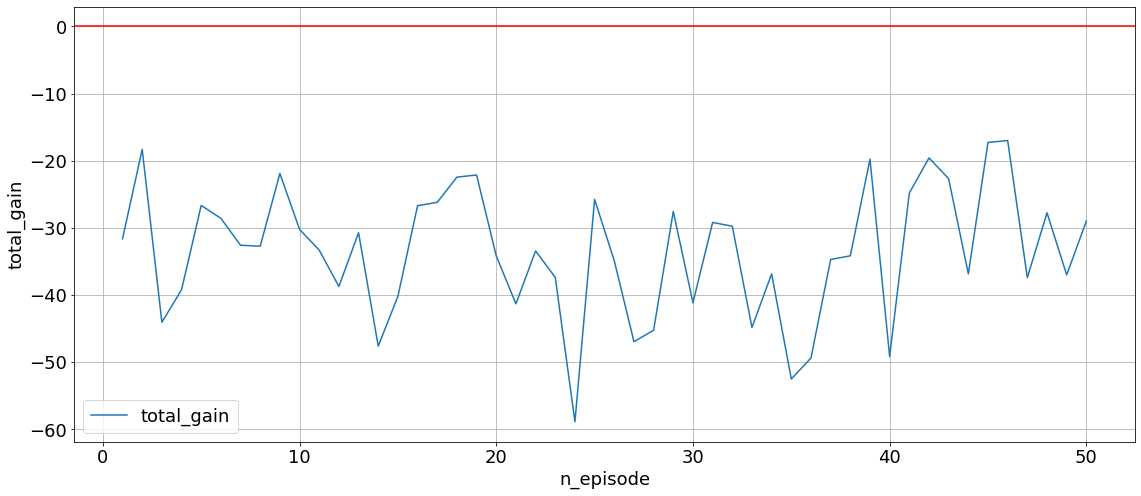

<ipython-input-17-0b145d364ecc>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


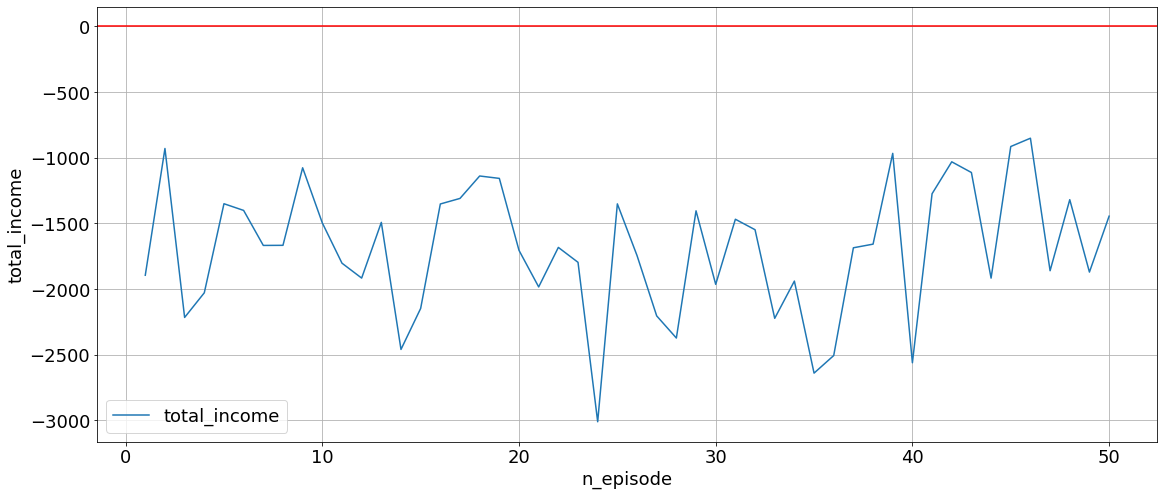

<ipython-input-17-0b145d364ecc>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


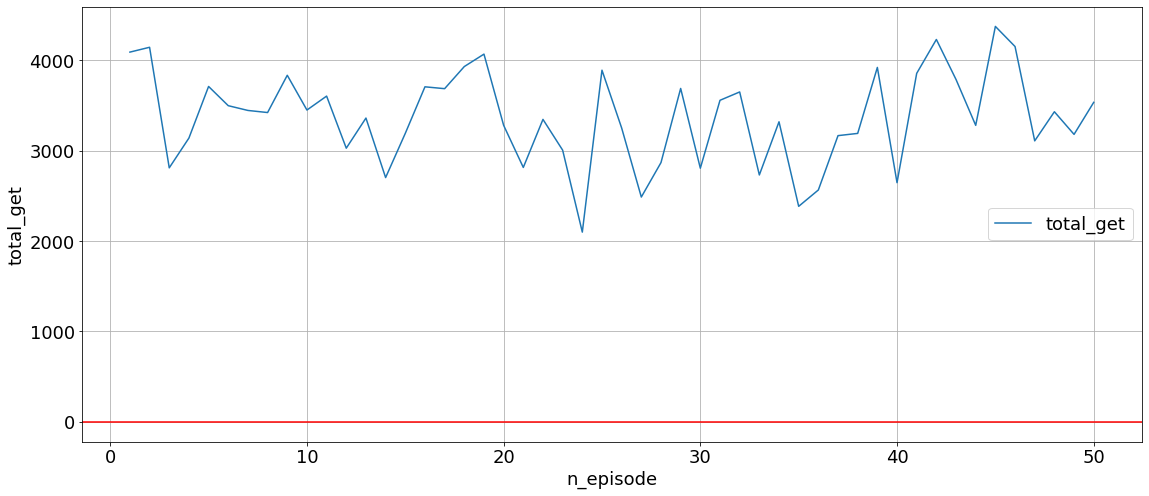

<ipython-input-17-0b145d364ecc>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


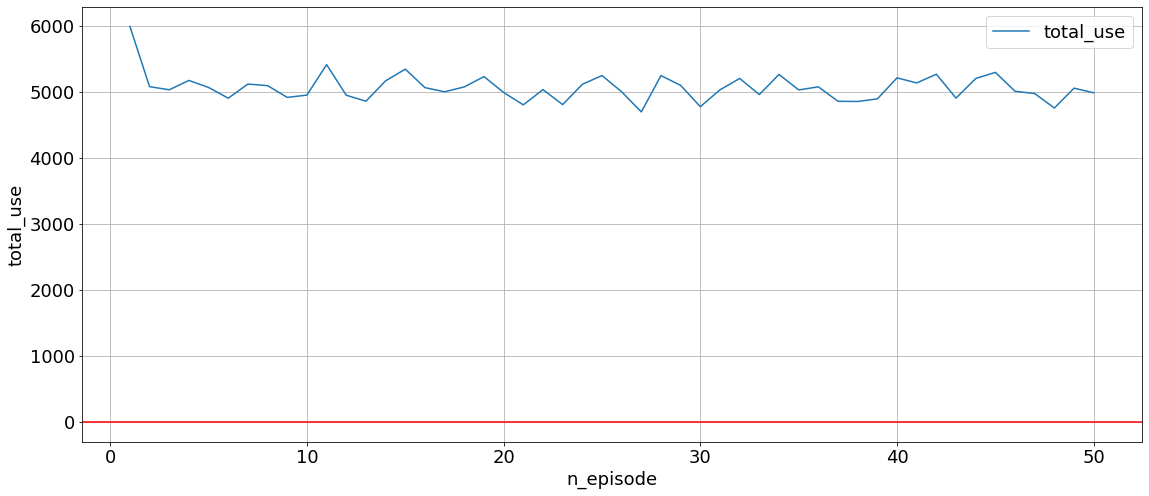

<ipython-input-17-0b145d364ecc>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


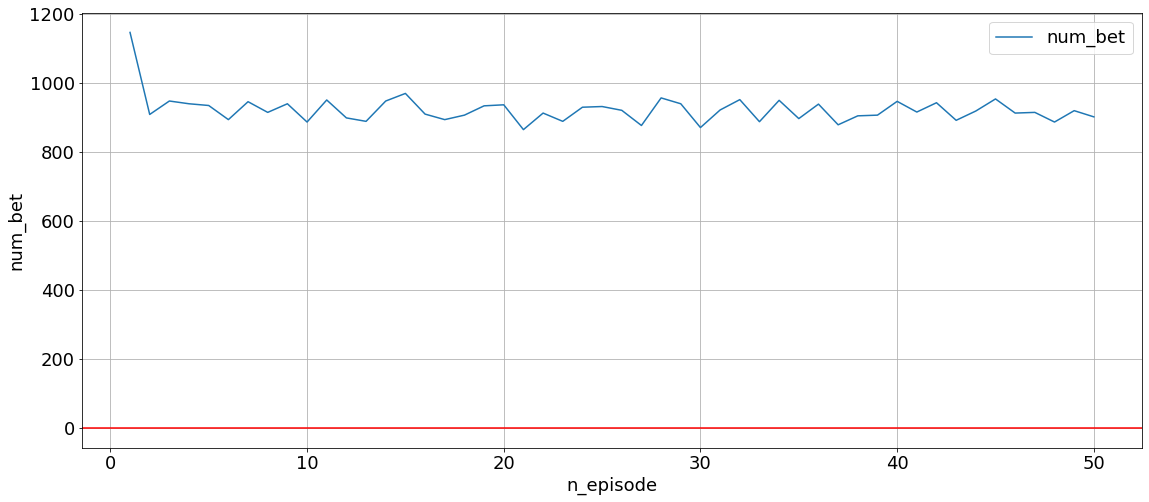

<ipython-input-17-0b145d364ecc>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


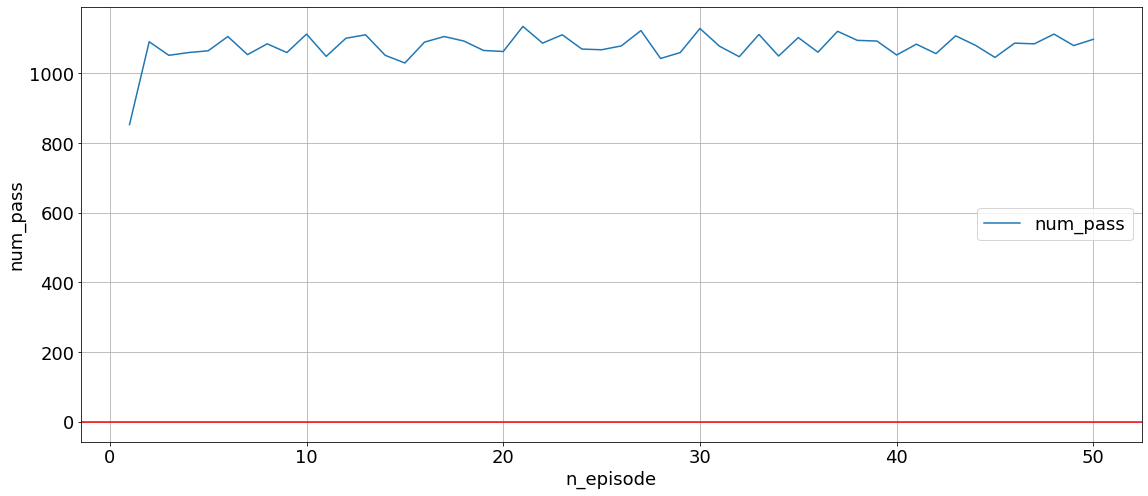

<ipython-input-17-0b145d364ecc>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


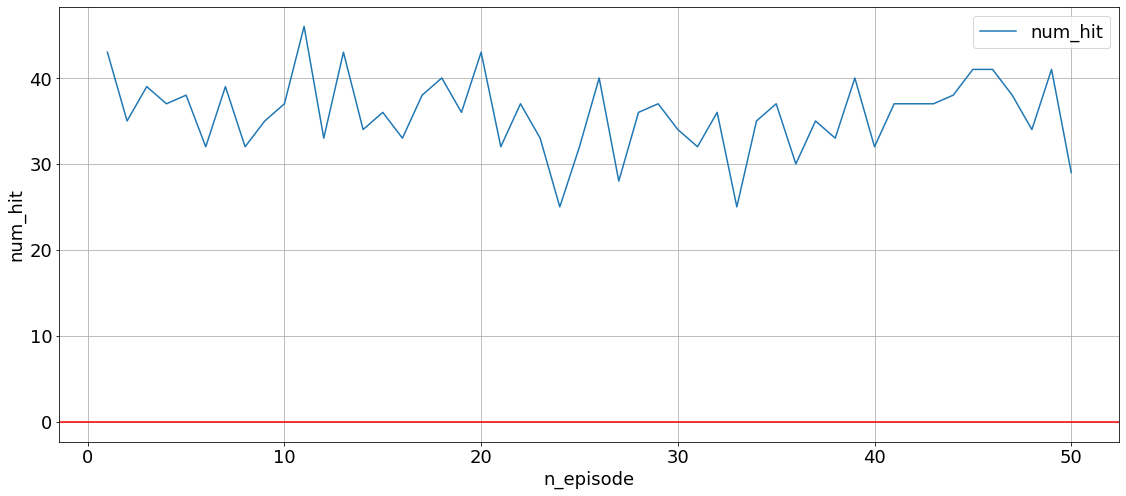

<ipython-input-17-0b145d364ecc>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


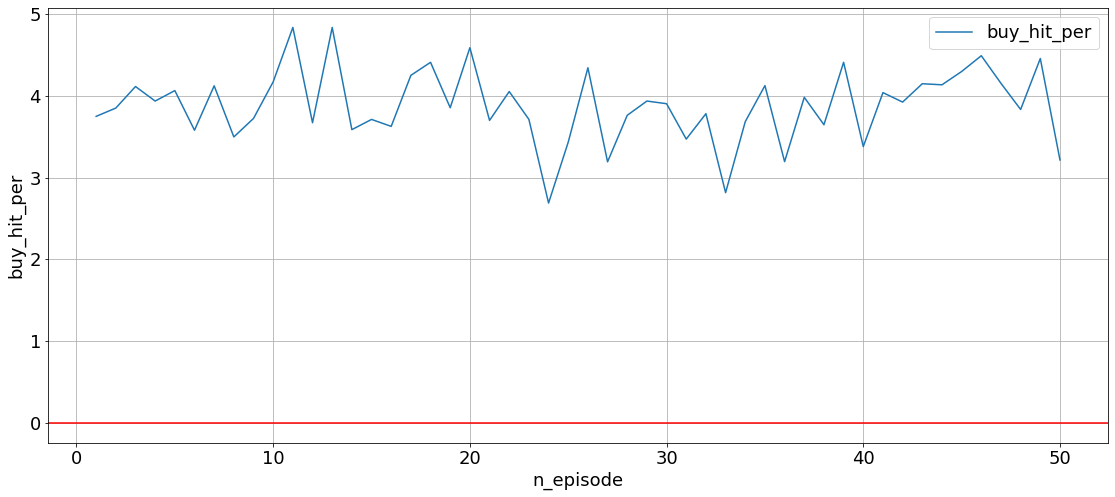

<ipython-input-17-0b145d364ecc>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


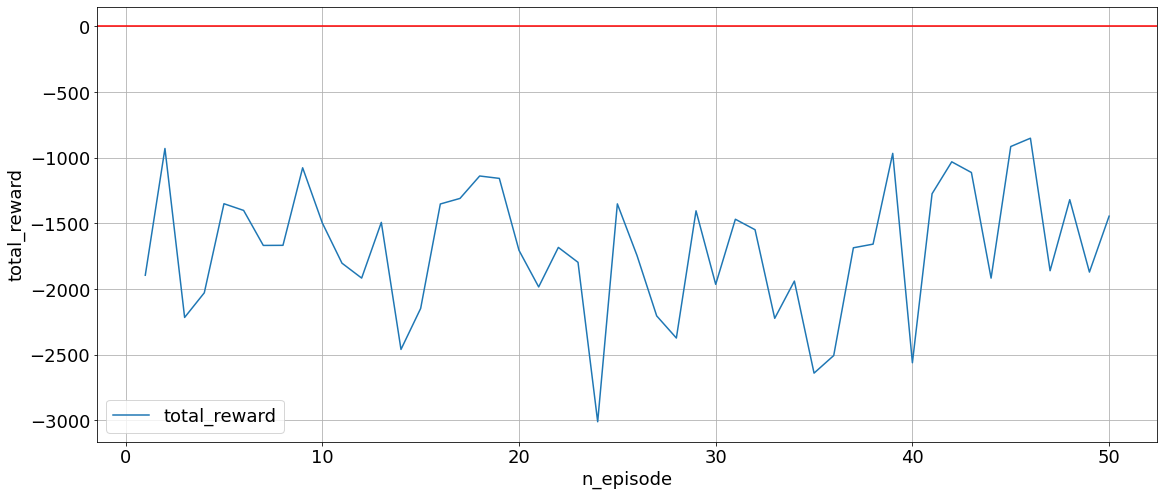

<ipython-input-17-0b145d364ecc>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


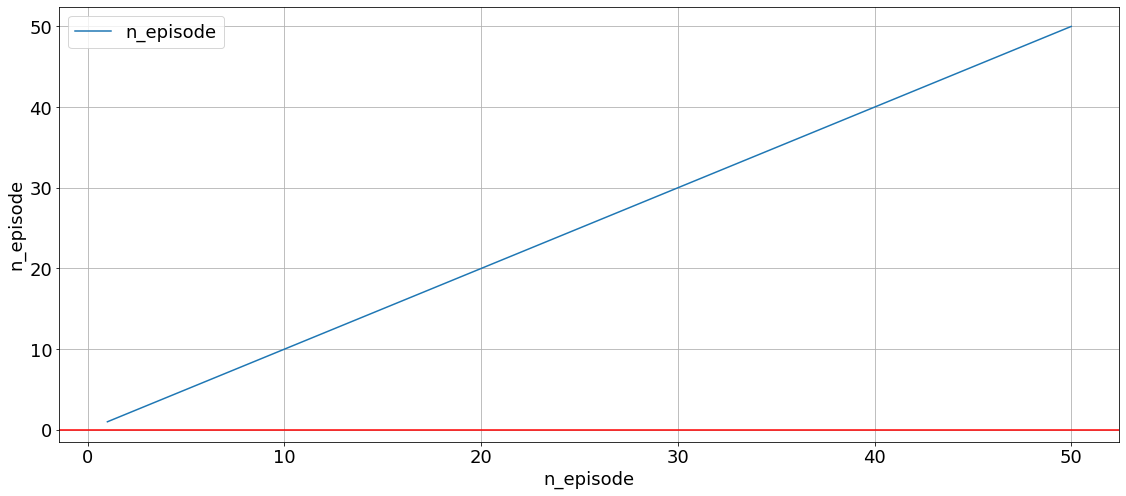

In [17]:
def larning_plt(df,x_n,y_n):#2本軸でのグラフの描写
    fig = plt.figure(figsize=(19,8))
    plt.tick_params(colors='black')
    plt.rcParams["font.size"] = 18
    fig.set_facecolor(color='white')

    x=df[x_n].values
    y=df[y_n].values

    ax1 = fig.add_subplot()
    #ax1.plot(x, y,label=y_n, marker="o")
    ax1.plot(x, y,label=y_n)
    ax1.tick_params()
    
    h1, l1 = ax1.get_legend_handles_labels()
    ax1.legend(h1, l1)

    ax1.set_xlabel(x_n)
    ax1.set_ylabel(y_n)
    plt.axhline(y=0,color='red')
    plt.grid()
    plt.show()
    return None

for col in scores_df.columns:
    x_n='n_episode'
    y_n=col
    larning_plt(scores_df,x_n,y_n)

### 学習が終わったエージェントの読み込みと，それを用いての再確認テスト・未知データテスト

In [ ]:
def split_race_data(race_df,race_ID):#レースのID(インデックス)を渡して，レースの情報を学習時などに使いやすい形に切り分けるメソッド
    race_row=race_df.iloc[race_ID]#対象のレースを切り抜き(series型)
    result_com=race_row['result_com']
    return_money=race_row['money']
    racer_ID=race_row['money']
    race_date=race_row['date']
    race_data=race_row.drop(['date',"result_com","money"]).values
    race_data_label=race_row.drop(['date',"result_com","money"]).index

    #race_data:選手情報やボート・モータ番号などの予測用データが入った配列
    #race_data_label:予測用データの役割を示す配列(pandasの列名（カラム）がこれに該当する)
    #race_dataがobsに該当する
    return result_com,return_money,race_data,race_data_label,race_date


def calc_race_gain(race_df,race_ID,action,target_com):#envのステップ関数から応用，１レース当たりの報酬計算（未知データでのテスト用）
    #actionとrace_IDは対応したものを渡す，渡したIDと行動を照らし合わせて収益計算を行う．
    #result_com,return_money,race_data,race_data_label,race_date=self.split_race_data(self.race_ID)#いろいろ算出用にレースデータの抜き取り
    result_com,return_money,race_data,race_data_label,race_date=split_race_data(race_df,race_ID)#いろいろ算出用にレースデータの抜き取り
    return_money_magni=return_money/100#配当金を倍率に変換
    #state = self.state
    #当たったかどうかの判別と，リターンの算出
    #race_use=0
    race_get=0
    race_use=action
    #race_use+=action*self.bet_coefficient
    if (action!=0):#的中か否かの判別と収益計算
        #if result_com==1:#購買行動を行っていたかつ，的中した      
        if result_com==target_com:#購買行動を行っていたかつ，的中した         
            race_get=action*return_money_magni#return_money_magni:配当の倍率(magnification)
        else:
            race_get=-1*action
    else:
        race_get=0

    next_race_ID=race_ID+1#次の状態を抜き出すためにIDに1を足す
    if next_race_ID>(len(race_df)-1):#次の状態(レース)がなくなったら終了
        done=True
        state=None
        reward=None
    else:
        result_com_next,return_money_next,race_data_next,race_data_label_next,race_date_next=split_race_data(race_df,next_race_ID)


    return np.array(race_data_next), race_get

In [24]:
from chainer import serializers


place_name='asiya'
#cash=100000#所持金
cash=10000#所持金
target_com=5
#target_com=2

result_filepath="../boatracer_BOT_making/bot_database/{place_name}/{place_name}_train/train_{place_name}.csv".format(place_name=place_name)#作成したデータの書き込み先#使用するデータの読み込み
test_df=pd.read_csv(result_filepath)
test_df=test_df.drop(["Unnamed: 0"],axis=1)
test_df.head()
test_df=data_making(test_df)#前処理
#sample_race_df[(sample_race_df['date'].dt.year>2019)&(sample_race_df['date'].dt.year<=2021)]
test_df=test_df[test_df['date'].dt.year>2020]#検証用データに答えが漏れないように切り抜く

#Q関数の設定
ex_result_com,ex_return_money,ex_race_data,ex_race_data_label,ex_race_date=split_race_data(test_df,0)
obs_size = len(ex_race_data)
n_actions = 11
q_func = QFunction(obs_size, n_actions)
q_func.to_gpu(0)
#q_func.to_gpu(0) ## GPUを使いたい人はこのコメントを外す

#最適化手法とパラメータ設定
optimizer = chainer.optimizers.Adam(eps=1e-2)
optimizer.setup(q_func) #設計したq関数の最適化にAdamを使う
gamma = 0.5#報酬の割引率.過去の結果をどのくらい重要視するか
#gamma = 0.06#報酬の割引率.過去の結果をどのくらい重要視するか
explorer = chainerrl.explorers.ConstantEpsilonGreedy(#次の戦略を考えるときの方法
    epsilon=0.5, random_action_func=asiya_env.random_action_func)
replay_buffer = chainerrl.replay_buffer.ReplayBuffer(capacity = 10**6)#Replayを実行するかどうか
phi = lambda x:x.astype(np.float32, copy=False)##型の変換(chainerはfloat32型。float64は駄目)
#===========================================================




#save_agent_pass='agent/test_model'
save_agent_pass='agent/backup/gamma_05_gain45_agent'
# load_agent = chainerrl.agents.DoubleDQN(
#     q_func, optimizer, replay_buffer, gamma, explorer,
#     replay_start_size=500, update_interval=1,
#     target_update_interval=100, phi=phi)
load_agent = chainerrl.agents.DoubleDQN(
    q_func, optimizer, replay_buffer, gamma, explorer,
    replay_start_size=500, update_interval=1,
    target_update_interval=100, phi=phi)
load_agent.load(save_agent_pass)


#試しに未知データで行動させてみる
max_episode_len = 2000
#start = time.time()
episode_step=list()
result_com_next,return_money_next,obs,race_data_label_next,race_date_next=split_race_data(test_df,0)
reward = 0
done = False
R = 0  # return (sum of rewards)
t = 0  # time step
while t < max_episode_len:
    action = load_agent.act(obs)
    #ここのところ要確認！！！しっかりとactionとobsが対応しているか見る！！
    obs, race_get=calc_race_gain(test_df,t,action,target_com)#ここのobsは次のレースデータ
    print(action)
    R += race_get
    t += 1

print(R)



{'total_gain': 0, 'total_income': 0, 'total_get': 0, 'total_use': 0, 'num_bet': 0, 'num_pass': 1, 'num_hit': 0, 'buy_hit_per': 0, 'total_reward': 0}
{'total_gain': 0, 'total_income': 0, 'total_get': 0, 'total_use': 0, 'num_bet': 0, 'num_pass': 2, 'num_hit': 0, 'buy_hit_per': 0, 'total_reward': 0}
{'total_gain': 0, 'total_income': 0, 'total_get': 0, 'total_use': 0, 'num_bet': 0, 'num_pass': 3, 'num_hit': 0, 'buy_hit_per': 0, 'total_reward': 0}
{'total_gain': 0, 'total_income': 0, 'total_get': 0, 'total_use': 0, 'num_bet': 0, 'num_pass': 4, 'num_hit': 0, 'buy_hit_per': 0, 'total_reward': 0}
{'total_gain': 0, 'total_income': -10, 'total_get': 0, 'total_use': 10, 'num_bet': 1, 'num_pass': 4, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -10}
{'total_gain': 0, 'total_income': -10, 'total_get': 0, 'total_use': 10, 'num_bet': 1, 'num_pass': 5, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -10}
{'total_gain': 0, 'total_income': -10, 'total_get': 0, 'total_use': 10, 'num_bet': 1, 'num_p

{'total_gain': 0, 'total_income': -13, 'total_get': 0, 'total_use': 13, 'num_bet': 2, 'num_pass': 68, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -13}
{'total_gain': 0, 'total_income': -13, 'total_get': 0, 'total_use': 13, 'num_bet': 2, 'num_pass': 69, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -13}
{'total_gain': 0, 'total_income': -13, 'total_get': 0, 'total_use': 13, 'num_bet': 2, 'num_pass': 70, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -13}
{'total_gain': 0, 'total_income': -13, 'total_get': 0, 'total_use': 13, 'num_bet': 2, 'num_pass': 71, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -13}
{'total_gain': 0, 'total_income': -13, 'total_get': 0, 'total_use': 13, 'num_bet': 2, 'num_pass': 72, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -13}
{'total_gain': 0, 'total_income': -13, 'total_get': 0, 'total_use': 13, 'num_bet': 2, 'num_pass': 73, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -13}
{'total_gain': 0, 'total_income': -13, 'total_get': 0, 'to

{'total_gain': 0, 'total_income': -23, 'total_get': 0, 'total_use': 23, 'num_bet': 3, 'num_pass': 151, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -23}
{'total_gain': 0, 'total_income': -23, 'total_get': 0, 'total_use': 23, 'num_bet': 3, 'num_pass': 152, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -23}
{'total_gain': 0, 'total_income': -23, 'total_get': 0, 'total_use': 23, 'num_bet': 3, 'num_pass': 153, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -23}
{'total_gain': 0, 'total_income': -23, 'total_get': 0, 'total_use': 23, 'num_bet': 3, 'num_pass': 154, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -23}
{'total_gain': 0, 'total_income': -23, 'total_get': 0, 'total_use': 23, 'num_bet': 3, 'num_pass': 155, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -23}
{'total_gain': 0, 'total_income': -23, 'total_get': 0, 'total_use': 23, 'num_bet': 3, 'num_pass': 156, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -23}
{'total_gain': 0, 'total_income': -23, 'total_get': 

{'total_gain': 0, 'total_income': -73, 'total_get': 0, 'total_use': 73, 'num_bet': 8, 'num_pass': 240, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -73}
{'total_gain': 0, 'total_income': -73, 'total_get': 0, 'total_use': 73, 'num_bet': 8, 'num_pass': 241, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -73}
{'total_gain': 0, 'total_income': -73, 'total_get': 0, 'total_use': 73, 'num_bet': 8, 'num_pass': 242, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -73}
{'total_gain': 0, 'total_income': -73, 'total_get': 0, 'total_use': 73, 'num_bet': 8, 'num_pass': 243, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -73}
{'total_gain': 0, 'total_income': -73, 'total_get': 0, 'total_use': 73, 'num_bet': 8, 'num_pass': 244, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -73}
{'total_gain': 0, 'total_income': -73, 'total_get': 0, 'total_use': 73, 'num_bet': 8, 'num_pass': 245, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -73}
{'total_gain': 0, 'total_income': -73, 'total_get': 

{'total_gain': 0, 'total_income': -73, 'total_get': 0, 'total_use': 73, 'num_bet': 8, 'num_pass': 334, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -73}
{'total_gain': 0, 'total_income': -73, 'total_get': 0, 'total_use': 73, 'num_bet': 8, 'num_pass': 335, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -73}
{'total_gain': 0, 'total_income': -73, 'total_get': 0, 'total_use': 73, 'num_bet': 8, 'num_pass': 336, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -73}
{'total_gain': 0, 'total_income': -73, 'total_get': 0, 'total_use': 73, 'num_bet': 8, 'num_pass': 337, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -73}
{'total_gain': 0, 'total_income': -73, 'total_get': 0, 'total_use': 73, 'num_bet': 8, 'num_pass': 338, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -73}
{'total_gain': 0, 'total_income': -73, 'total_get': 0, 'total_use': 73, 'num_bet': 8, 'num_pass': 339, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -73}
{'total_gain': 0, 'total_income': -73, 'total_get': 

{'total_gain': 0, 'total_income': -133, 'total_get': 0, 'total_use': 133, 'num_bet': 14, 'num_pass': 420, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -133}
{'total_gain': 0, 'total_income': -143, 'total_get': 0, 'total_use': 143, 'num_bet': 15, 'num_pass': 420, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -143}
{'total_gain': 0, 'total_income': -143, 'total_get': 0, 'total_use': 143, 'num_bet': 15, 'num_pass': 421, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -143}
{'total_gain': 0, 'total_income': -143, 'total_get': 0, 'total_use': 143, 'num_bet': 15, 'num_pass': 422, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -143}
{'total_gain': 0, 'total_income': -143, 'total_get': 0, 'total_use': 143, 'num_bet': 15, 'num_pass': 423, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -143}
{'total_gain': 0, 'total_income': -143, 'total_get': 0, 'total_use': 143, 'num_bet': 15, 'num_pass': 424, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -143}
{'total_gain': 0, 'total_inc

{'total_gain': 0, 'total_income': -153, 'total_get': 0, 'total_use': 153, 'num_bet': 16, 'num_pass': 512, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -153}
{'total_gain': 0, 'total_income': -153, 'total_get': 0, 'total_use': 153, 'num_bet': 16, 'num_pass': 513, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -153}
{'total_gain': 0, 'total_income': -153, 'total_get': 0, 'total_use': 153, 'num_bet': 16, 'num_pass': 514, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -153}
{'total_gain': 0, 'total_income': -153, 'total_get': 0, 'total_use': 153, 'num_bet': 16, 'num_pass': 515, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -153}
{'total_gain': 0, 'total_income': -153, 'total_get': 0, 'total_use': 153, 'num_bet': 16, 'num_pass': 516, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -153}
{'total_gain': 0, 'total_income': -153, 'total_get': 0, 'total_use': 153, 'num_bet': 16, 'num_pass': 517, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -153}
{'total_gain': 0, 'total_inc

{'total_gain': 0, 'total_income': -176, 'total_get': 0, 'total_use': 176, 'num_bet': 19, 'num_pass': 601, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -176}
{'total_gain': 0, 'total_income': -176, 'total_get': 0, 'total_use': 176, 'num_bet': 19, 'num_pass': 602, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -176}
{'total_gain': 0, 'total_income': -176, 'total_get': 0, 'total_use': 176, 'num_bet': 19, 'num_pass': 603, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -176}
{'total_gain': 0, 'total_income': -176, 'total_get': 0, 'total_use': 176, 'num_bet': 19, 'num_pass': 604, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -176}
{'total_gain': 0, 'total_income': -176, 'total_get': 0, 'total_use': 176, 'num_bet': 19, 'num_pass': 605, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -176}
{'total_gain': 0, 'total_income': -176, 'total_get': 0, 'total_use': 176, 'num_bet': 19, 'num_pass': 606, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -176}
{'total_gain': 0, 'total_inc

{'total_gain': 0, 'total_income': -216, 'total_get': 0, 'total_use': 216, 'num_bet': 23, 'num_pass': 689, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -216}
{'total_gain': 0, 'total_income': -216, 'total_get': 0, 'total_use': 216, 'num_bet': 23, 'num_pass': 690, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -216}
{'total_gain': 0, 'total_income': -216, 'total_get': 0, 'total_use': 216, 'num_bet': 23, 'num_pass': 691, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -216}
{'total_gain': 0, 'total_income': -216, 'total_get': 0, 'total_use': 216, 'num_bet': 23, 'num_pass': 692, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -216}
{'total_gain': 0, 'total_income': -216, 'total_get': 0, 'total_use': 216, 'num_bet': 23, 'num_pass': 693, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -216}
{'total_gain': 0, 'total_income': -216, 'total_get': 0, 'total_use': 216, 'num_bet': 23, 'num_pass': 694, 'num_hit': 0, 'buy_hit_per': 0.0, 'total_reward': -216}
{'total_gain': 0, 'total_inc

{'total_gain': -64.60176991150442, 'total_income': -146.0, 'total_get': 80.0, 'total_use': 226, 'num_bet': 24, 'num_pass': 782, 'num_hit': 1, 'buy_hit_per': 4.166666666666666, 'total_reward': -146.0}
{'total_gain': -64.60176991150442, 'total_income': -146.0, 'total_get': 80.0, 'total_use': 226, 'num_bet': 24, 'num_pass': 783, 'num_hit': 1, 'buy_hit_per': 4.166666666666666, 'total_reward': -146.0}
{'total_gain': -64.60176991150442, 'total_income': -146.0, 'total_get': 80.0, 'total_use': 226, 'num_bet': 24, 'num_pass': 784, 'num_hit': 1, 'buy_hit_per': 4.166666666666666, 'total_reward': -146.0}
{'total_gain': -64.60176991150442, 'total_income': -146.0, 'total_get': 80.0, 'total_use': 226, 'num_bet': 24, 'num_pass': 785, 'num_hit': 1, 'buy_hit_per': 4.166666666666666, 'total_reward': -146.0}
{'total_gain': -64.60176991150442, 'total_income': -146.0, 'total_get': 80.0, 'total_use': 226, 'num_bet': 24, 'num_pass': 786, 'num_hit': 1, 'buy_hit_per': 4.166666666666666, 'total_reward': -146.0}


{'total_gain': -64.60176991150442, 'total_income': -146.0, 'total_get': 80.0, 'total_use': 226, 'num_bet': 24, 'num_pass': 875, 'num_hit': 1, 'buy_hit_per': 4.166666666666666, 'total_reward': -146.0}
{'total_gain': -64.60176991150442, 'total_income': -146.0, 'total_get': 80.0, 'total_use': 226, 'num_bet': 24, 'num_pass': 876, 'num_hit': 1, 'buy_hit_per': 4.166666666666666, 'total_reward': -146.0}
{'total_gain': -64.60176991150442, 'total_income': -146.0, 'total_get': 80.0, 'total_use': 226, 'num_bet': 24, 'num_pass': 877, 'num_hit': 1, 'buy_hit_per': 4.166666666666666, 'total_reward': -146.0}
{'total_gain': -64.60176991150442, 'total_income': -146.0, 'total_get': 80.0, 'total_use': 226, 'num_bet': 24, 'num_pass': 878, 'num_hit': 1, 'buy_hit_per': 4.166666666666666, 'total_reward': -146.0}
{'total_gain': -64.60176991150442, 'total_income': -146.0, 'total_get': 80.0, 'total_use': 226, 'num_bet': 24, 'num_pass': 879, 'num_hit': 1, 'buy_hit_per': 4.166666666666666, 'total_reward': -146.0}


{'total_gain': -69.92481203007519, 'total_income': -186.0, 'total_get': 80.0, 'total_use': 266, 'num_bet': 28, 'num_pass': 964, 'num_hit': 1, 'buy_hit_per': 3.571428571428571, 'total_reward': -186.0}
{'total_gain': -69.92481203007519, 'total_income': -186.0, 'total_get': 80.0, 'total_use': 266, 'num_bet': 28, 'num_pass': 965, 'num_hit': 1, 'buy_hit_per': 3.571428571428571, 'total_reward': -186.0}
{'total_gain': -69.92481203007519, 'total_income': -186.0, 'total_get': 80.0, 'total_use': 266, 'num_bet': 28, 'num_pass': 966, 'num_hit': 1, 'buy_hit_per': 3.571428571428571, 'total_reward': -186.0}
{'total_gain': -69.92481203007519, 'total_income': -186.0, 'total_get': 80.0, 'total_use': 266, 'num_bet': 28, 'num_pass': 967, 'num_hit': 1, 'buy_hit_per': 3.571428571428571, 'total_reward': -186.0}
{'total_gain': -69.92481203007519, 'total_income': -186.0, 'total_get': 80.0, 'total_use': 266, 'num_bet': 28, 'num_pass': 968, 'num_hit': 1, 'buy_hit_per': 3.571428571428571, 'total_reward': -186.0}


{'total_gain': -69.92481203007519, 'total_income': -186.0, 'total_get': 80.0, 'total_use': 266, 'num_bet': 28, 'num_pass': 1057, 'num_hit': 1, 'buy_hit_per': 3.571428571428571, 'total_reward': -186.0}
{'total_gain': -69.92481203007519, 'total_income': -186.0, 'total_get': 80.0, 'total_use': 266, 'num_bet': 28, 'num_pass': 1058, 'num_hit': 1, 'buy_hit_per': 3.571428571428571, 'total_reward': -186.0}
{'total_gain': -69.92481203007519, 'total_income': -186.0, 'total_get': 80.0, 'total_use': 266, 'num_bet': 28, 'num_pass': 1059, 'num_hit': 1, 'buy_hit_per': 3.571428571428571, 'total_reward': -186.0}
{'total_gain': -69.92481203007519, 'total_income': -186.0, 'total_get': 80.0, 'total_use': 266, 'num_bet': 28, 'num_pass': 1060, 'num_hit': 1, 'buy_hit_per': 3.571428571428571, 'total_reward': -186.0}
{'total_gain': -69.92481203007519, 'total_income': -186.0, 'total_get': 80.0, 'total_use': 266, 'num_bet': 28, 'num_pass': 1061, 'num_hit': 1, 'buy_hit_per': 3.571428571428571, 'total_reward': -18

{'total_gain': -38.85135135135135, 'total_income': -115.0, 'total_get': 181.0, 'total_use': 296, 'num_bet': 31, 'num_pass': 1146, 'num_hit': 2, 'buy_hit_per': 6.451612903225806, 'total_reward': -115.0}
{'total_gain': -38.85135135135135, 'total_income': -115.0, 'total_get': 181.0, 'total_use': 296, 'num_bet': 31, 'num_pass': 1147, 'num_hit': 2, 'buy_hit_per': 6.451612903225806, 'total_reward': -115.0}
{'total_gain': -38.85135135135135, 'total_income': -115.0, 'total_get': 181.0, 'total_use': 296, 'num_bet': 31, 'num_pass': 1148, 'num_hit': 2, 'buy_hit_per': 6.451612903225806, 'total_reward': -115.0}
{'total_gain': -38.85135135135135, 'total_income': -115.0, 'total_get': 181.0, 'total_use': 296, 'num_bet': 31, 'num_pass': 1149, 'num_hit': 2, 'buy_hit_per': 6.451612903225806, 'total_reward': -115.0}
{'total_gain': -38.85135135135135, 'total_income': -115.0, 'total_get': 181.0, 'total_use': 296, 'num_bet': 31, 'num_pass': 1150, 'num_hit': 2, 'buy_hit_per': 6.451612903225806, 'total_reward'

{'total_gain': -38.85135135135135, 'total_income': -115.0, 'total_get': 181.0, 'total_use': 296, 'num_bet': 31, 'num_pass': 1237, 'num_hit': 2, 'buy_hit_per': 6.451612903225806, 'total_reward': -115.0}
{'total_gain': -38.85135135135135, 'total_income': -115.0, 'total_get': 181.0, 'total_use': 296, 'num_bet': 31, 'num_pass': 1238, 'num_hit': 2, 'buy_hit_per': 6.451612903225806, 'total_reward': -115.0}
{'total_gain': -38.85135135135135, 'total_income': -115.0, 'total_get': 181.0, 'total_use': 296, 'num_bet': 31, 'num_pass': 1239, 'num_hit': 2, 'buy_hit_per': 6.451612903225806, 'total_reward': -115.0}
{'total_gain': -38.85135135135135, 'total_income': -115.0, 'total_get': 181.0, 'total_use': 296, 'num_bet': 31, 'num_pass': 1240, 'num_hit': 2, 'buy_hit_per': 6.451612903225806, 'total_reward': -115.0}
{'total_gain': -38.85135135135135, 'total_income': -115.0, 'total_get': 181.0, 'total_use': 296, 'num_bet': 31, 'num_pass': 1241, 'num_hit': 2, 'buy_hit_per': 6.451612903225806, 'total_reward'

{'total_gain': -44.47852760736196, 'total_income': -145.0, 'total_get': 181.0, 'total_use': 326, 'num_bet': 34, 'num_pass': 1327, 'num_hit': 2, 'buy_hit_per': 5.88235294117647, 'total_reward': -145.0}
{'total_gain': -44.47852760736196, 'total_income': -145.0, 'total_get': 181.0, 'total_use': 326, 'num_bet': 34, 'num_pass': 1328, 'num_hit': 2, 'buy_hit_per': 5.88235294117647, 'total_reward': -145.0}
{'total_gain': -44.47852760736196, 'total_income': -145.0, 'total_get': 181.0, 'total_use': 326, 'num_bet': 34, 'num_pass': 1329, 'num_hit': 2, 'buy_hit_per': 5.88235294117647, 'total_reward': -145.0}
{'total_gain': -44.47852760736196, 'total_income': -145.0, 'total_get': 181.0, 'total_use': 326, 'num_bet': 34, 'num_pass': 1330, 'num_hit': 2, 'buy_hit_per': 5.88235294117647, 'total_reward': -145.0}
{'total_gain': -44.47852760736196, 'total_income': -145.0, 'total_get': 181.0, 'total_use': 326, 'num_bet': 34, 'num_pass': 1331, 'num_hit': 2, 'buy_hit_per': 5.88235294117647, 'total_reward': -14

{'total_gain': -44.47852760736196, 'total_income': -145.0, 'total_get': 181.0, 'total_use': 326, 'num_bet': 34, 'num_pass': 1417, 'num_hit': 2, 'buy_hit_per': 5.88235294117647, 'total_reward': -145.0}
{'total_gain': -44.47852760736196, 'total_income': -145.0, 'total_get': 181.0, 'total_use': 326, 'num_bet': 34, 'num_pass': 1418, 'num_hit': 2, 'buy_hit_per': 5.88235294117647, 'total_reward': -145.0}
{'total_gain': -44.47852760736196, 'total_income': -145.0, 'total_get': 181.0, 'total_use': 326, 'num_bet': 34, 'num_pass': 1419, 'num_hit': 2, 'buy_hit_per': 5.88235294117647, 'total_reward': -145.0}
{'total_gain': -44.47852760736196, 'total_income': -145.0, 'total_get': 181.0, 'total_use': 326, 'num_bet': 34, 'num_pass': 1420, 'num_hit': 2, 'buy_hit_per': 5.88235294117647, 'total_reward': -145.0}
{'total_gain': -44.47852760736196, 'total_income': -145.0, 'total_get': 181.0, 'total_use': 326, 'num_bet': 34, 'num_pass': 1421, 'num_hit': 2, 'buy_hit_per': 5.88235294117647, 'total_reward': -14

{'total_gain': -48.87005649717514, 'total_income': -173.0, 'total_get': 181.0, 'total_use': 354, 'num_bet': 37, 'num_pass': 1508, 'num_hit': 2, 'buy_hit_per': 5.405405405405405, 'total_reward': -173.0}
{'total_gain': -50.27472527472527, 'total_income': -183.0, 'total_get': 181.0, 'total_use': 364, 'num_bet': 38, 'num_pass': 1508, 'num_hit': 2, 'buy_hit_per': 5.263157894736842, 'total_reward': -183.0}
{'total_gain': -51.60427807486631, 'total_income': -193.0, 'total_get': 181.0, 'total_use': 374, 'num_bet': 39, 'num_pass': 1508, 'num_hit': 2, 'buy_hit_per': 5.128205128205128, 'total_reward': -193.0}
{'total_gain': -51.60427807486631, 'total_income': -193.0, 'total_get': 181.0, 'total_use': 374, 'num_bet': 39, 'num_pass': 1509, 'num_hit': 2, 'buy_hit_per': 5.128205128205128, 'total_reward': -193.0}
{'total_gain': -51.60427807486631, 'total_income': -193.0, 'total_get': 181.0, 'total_use': 374, 'num_bet': 39, 'num_pass': 1510, 'num_hit': 2, 'buy_hit_per': 5.128205128205128, 'total_reward'

{'total_gain': -22.0253164556962, 'total_income': -87.0, 'total_get': 308.0, 'total_use': 395, 'num_bet': 42, 'num_pass': 1596, 'num_hit': 3, 'buy_hit_per': 7.142857142857142, 'total_reward': -87.0}
{'total_gain': -22.0253164556962, 'total_income': -87.0, 'total_get': 308.0, 'total_use': 395, 'num_bet': 42, 'num_pass': 1597, 'num_hit': 3, 'buy_hit_per': 7.142857142857142, 'total_reward': -87.0}
{'total_gain': -22.0253164556962, 'total_income': -87.0, 'total_get': 308.0, 'total_use': 395, 'num_bet': 42, 'num_pass': 1598, 'num_hit': 3, 'buy_hit_per': 7.142857142857142, 'total_reward': -87.0}
{'total_gain': -22.0253164556962, 'total_income': -87.0, 'total_get': 308.0, 'total_use': 395, 'num_bet': 42, 'num_pass': 1599, 'num_hit': 3, 'buy_hit_per': 7.142857142857142, 'total_reward': -87.0}
{'total_gain': -22.0253164556962, 'total_income': -87.0, 'total_get': 308.0, 'total_use': 395, 'num_bet': 42, 'num_pass': 1600, 'num_hit': 3, 'buy_hit_per': 7.142857142857142, 'total_reward': -87.0}
{'tot

{'total_gain': -23.95061728395062, 'total_income': -97.0, 'total_get': 308.0, 'total_use': 405, 'num_bet': 43, 'num_pass': 1686, 'num_hit': 3, 'buy_hit_per': 6.976744186046512, 'total_reward': -97.0}
{'total_gain': -23.95061728395062, 'total_income': -97.0, 'total_get': 308.0, 'total_use': 405, 'num_bet': 43, 'num_pass': 1687, 'num_hit': 3, 'buy_hit_per': 6.976744186046512, 'total_reward': -97.0}
{'total_gain': -23.95061728395062, 'total_income': -97.0, 'total_get': 308.0, 'total_use': 405, 'num_bet': 43, 'num_pass': 1688, 'num_hit': 3, 'buy_hit_per': 6.976744186046512, 'total_reward': -97.0}
{'total_gain': -23.95061728395062, 'total_income': -97.0, 'total_get': 308.0, 'total_use': 405, 'num_bet': 43, 'num_pass': 1689, 'num_hit': 3, 'buy_hit_per': 6.976744186046512, 'total_reward': -97.0}
{'total_gain': -23.95061728395062, 'total_income': -97.0, 'total_get': 308.0, 'total_use': 405, 'num_bet': 43, 'num_pass': 1690, 'num_hit': 3, 'buy_hit_per': 6.976744186046512, 'total_reward': -97.0}


{'total_gain': -23.95061728395062, 'total_income': -97.0, 'total_get': 308.0, 'total_use': 405, 'num_bet': 43, 'num_pass': 1776, 'num_hit': 3, 'buy_hit_per': 6.976744186046512, 'total_reward': -97.0}
{'total_gain': -23.95061728395062, 'total_income': -97.0, 'total_get': 308.0, 'total_use': 405, 'num_bet': 43, 'num_pass': 1777, 'num_hit': 3, 'buy_hit_per': 6.976744186046512, 'total_reward': -97.0}
{'total_gain': -23.95061728395062, 'total_income': -97.0, 'total_get': 308.0, 'total_use': 405, 'num_bet': 43, 'num_pass': 1778, 'num_hit': 3, 'buy_hit_per': 6.976744186046512, 'total_reward': -97.0}
{'total_gain': -23.95061728395062, 'total_income': -97.0, 'total_get': 308.0, 'total_use': 405, 'num_bet': 43, 'num_pass': 1779, 'num_hit': 3, 'buy_hit_per': 6.976744186046512, 'total_reward': -97.0}
{'total_gain': -23.95061728395062, 'total_income': -97.0, 'total_get': 308.0, 'total_use': 405, 'num_bet': 43, 'num_pass': 1780, 'num_hit': 3, 'buy_hit_per': 6.976744186046512, 'total_reward': -97.0}


{'total_gain': -25.783132530120483, 'total_income': -107.0, 'total_get': 308.0, 'total_use': 415, 'num_bet': 44, 'num_pass': 1866, 'num_hit': 3, 'buy_hit_per': 6.8181818181818175, 'total_reward': -107.0}
{'total_gain': -25.783132530120483, 'total_income': -107.0, 'total_get': 308.0, 'total_use': 415, 'num_bet': 44, 'num_pass': 1867, 'num_hit': 3, 'buy_hit_per': 6.8181818181818175, 'total_reward': -107.0}
{'total_gain': -25.783132530120483, 'total_income': -107.0, 'total_get': 308.0, 'total_use': 415, 'num_bet': 44, 'num_pass': 1868, 'num_hit': 3, 'buy_hit_per': 6.8181818181818175, 'total_reward': -107.0}
{'total_gain': -25.783132530120483, 'total_income': -107.0, 'total_get': 308.0, 'total_use': 415, 'num_bet': 44, 'num_pass': 1869, 'num_hit': 3, 'buy_hit_per': 6.8181818181818175, 'total_reward': -107.0}
{'total_gain': -25.783132530120483, 'total_income': -107.0, 'total_get': 308.0, 'total_use': 415, 'num_bet': 44, 'num_pass': 1870, 'num_hit': 3, 'buy_hit_per': 6.8181818181818175, 'tot

In [23]:
R

-150.0

In [23]:
load_agent

### 保存したモデルを用いた，未知データ区間での成績確認

In [19]:
load_agent

## GPUの使用でどれくらい短縮効果があるかの確認

### GPUなし:911sec

In [7]:
place_name='asiya'
#cash=100000#所持金
cash=100000#所持金
target_com=5
#target_com=2

result_filepath="../boatracer_BOT_making/bot_database/{place_name}/{place_name}_train/train_{place_name}.csv".format(place_name=place_name)#作成したデータの書き込み先#使用するデータの読み込み
sample_race_df=pd.read_csv(result_filepath)
sample_race_df=sample_race_df.drop(["Unnamed: 0"],axis=1)
sample_race_df.head()
sample_race_df=data_making(sample_race_df)#前処理
asiya_env =BoatraceComEnv(target_com,sample_race_df,cash)#環境の作成（クラス）

#Q関数の設定
obs_size = asiya_env.obs_size
n_actions = asiya_env.n_action
q_func = QFunction(obs_size, n_actions)
#q_func.to_gpu(0) ## GPUを使いたい人はこのコメントを外す

#最適化手法とパラメータ設定
optimizer = chainer.optimizers.Adam(eps=1e-2)
optimizer.setup(q_func) #設計したq関数の最適化にAdamを使う
gamma = 0.80#報酬の割引率.過去の結果をどのくらい重要視するか
explorer = chainerrl.explorers.ConstantEpsilonGreedy(#次の戦略を考えるときの方法
    epsilon=0.3, random_action_func=asiya_env.random_action_func)
replay_buffer = chainerrl.replay_buffer.ReplayBuffer(capacity = 10**6)#Replayを実行するかどうか
phi = lambda x:x.astype(np.float32, copy=False)##型の変換(chainerはfloat32型。float64は駄目)

agent = chainerrl.agents.DoubleDQN(
    q_func, optimizer, replay_buffer, gamma, explorer,
    replay_start_size=500, update_interval=1,
    target_update_interval=100, phi=phi)

import time
n_episodes = 50
max_episode_len = 2000
start = time.time()
episode_step=list()
episode_gain=list()
for i in range(1, n_episodes + 1):
    obs = asiya_env.reset()
    reward = 0
    done = False
    R = 0  # return (sum of rewards)
    t = 0  # time step
    while not done and t < max_episode_len:
        action = agent.act_and_train(obs, reward)
        obs, reward, done, option = asiya_env.step(action)
        R += reward
        t += 1
        
    if i % 10 == 0:
        print('episode:', i,
              'R:', R,
              'statistics:', agent.get_statistics())
    agent.stop_episode_and_train(obs, reward, done)
    episode_step.append(i)
    episode_gain.append(asiya_env.total_gain)
    #エピソードごとの成績を作成
    
print('Finished, elapsed time : {}'.format(time.time()-start))
analysis_df=pd.DataFrame()
analysis_df['ep_step']=episode_step
analysis_df['ep_gain']=episode_gain


episode: 10 R: -269454.1750000002 statistics: [('average_q', -0.08670020672760897), ('average_loss', 112.53643541119972), ('n_updates', 19500)]
episode: 20 R: -231561.5200000003 statistics: [('average_q', -0.175727651092178), ('average_loss', 133.41969647892438), ('n_updates', 39500)]
episode: 30 R: -254537.3250000003 statistics: [('average_q', -0.12066549715352473), ('average_loss', 135.91506888733377), ('n_updates', 59500)]
episode: 40 R: -285264.0250000004 statistics: [('average_q', 0.025761359124444258), ('average_loss', 116.76136684894085), ('n_updates', 79500)]
episode: 50 R: -294924.93500000035 statistics: [('average_q', 0.006402642496736394), ('average_loss', 125.70122892190575), ('n_updates', 99500)]
Finished, elapsed time : 911.2012474536896


### GPUあり:665sec==早い！！,今度っからこっちでやる

In [8]:
place_name='asiya'
#cash=100000#所持金
cash=100000#所持金
target_com=5
#target_com=2

result_filepath="../boatracer_BOT_making/bot_database/{place_name}/{place_name}_train/train_{place_name}.csv".format(place_name=place_name)#作成したデータの書き込み先#使用するデータの読み込み
sample_race_df=pd.read_csv(result_filepath)
sample_race_df=sample_race_df.drop(["Unnamed: 0"],axis=1)
sample_race_df.head()
sample_race_df=data_making(sample_race_df)#前処理
asiya_env =BoatraceComEnv(target_com,sample_race_df,cash)#環境の作成（クラス）

#Q関数の設定
obs_size = asiya_env.obs_size
n_actions = asiya_env.n_action
q_func = QFunction(obs_size, n_actions)
q_func.to_gpu(0)
#q_func.to_gpu(0) ## GPUを使いたい人はこのコメントを外す

#最適化手法とパラメータ設定
optimizer = chainer.optimizers.Adam(eps=1e-2)
optimizer.setup(q_func) #設計したq関数の最適化にAdamを使う
gamma = 0.80#報酬の割引率.過去の結果をどのくらい重要視するか
explorer = chainerrl.explorers.ConstantEpsilonGreedy(#次の戦略を考えるときの方法
    epsilon=0.3, random_action_func=asiya_env.random_action_func)
replay_buffer = chainerrl.replay_buffer.ReplayBuffer(capacity = 10**6)#Replayを実行するかどうか
phi = lambda x:x.astype(np.float32, copy=False)##型の変換(chainerはfloat32型。float64は駄目)

agent = chainerrl.agents.DoubleDQN(
    q_func, optimizer, replay_buffer, gamma, explorer,
    replay_start_size=500, update_interval=1,
    target_update_interval=100, phi=phi)






import time
n_episodes = 50
max_episode_len = 2000
start = time.time()
episode_step=list()
episode_gain=list()
for i in range(1, n_episodes + 1):
    obs = asiya_env.reset()
    reward = 0
    done = False
    R = 0  # return (sum of rewards)
    t = 0  # time step
    while not done and t < max_episode_len:
        action = agent.act_and_train(obs, reward)
        obs, reward, done, option = asiya_env.step(action)
        R += reward
        t += 1
        
    if i % 10 == 0:
        print('episode:', i,
              'R:', R,
              'statistics:', agent.get_statistics())
    agent.stop_episode_and_train(obs, reward, done)
    episode_step.append(i)
    episode_gain.append(asiya_env.total_gain)
    #エピソードごとの成績を作成
    
print('Finished, elapsed time : {}'.format(time.time()-start))
analysis_df=pd.DataFrame()
analysis_df['ep_step']=episode_step
analysis_df['ep_gain']=episode_gain


episode: 10 R: -224802.09500000026 statistics: [('average_q', -0.06732089490786068), ('average_loss', 120.95386273199466), ('n_updates', 19500)]
episode: 20 R: -259868.58000000034 statistics: [('average_q', -0.23308289401661836), ('average_loss', 123.8925704501554), ('n_updates', 39500)]
episode: 30 R: -239620.52000000014 statistics: [('average_q', -0.16733844107282406), ('average_loss', 111.26403850712934), ('n_updates', 59500)]
episode: 40 R: -274908.9250000003 statistics: [('average_q', -0.12391317265966276), ('average_loss', 114.4313894115869), ('n_updates', 79500)]
episode: 50 R: -225254.43500000035 statistics: [('average_q', -0.1331655710723999), ('average_loss', 124.27176601905643), ('n_updates', 99500)]
Finished, elapsed time : 665.4870507717133


## 成長過程をもっと可視化する

In [ ]:
place_name='asiya'
#cash=100000#所持金
cash=100000#所持金
target_com=5
#target_com=2

result_filepath="../boatracer_BOT_making/bot_database/{place_name}/{place_name}_train/train_{place_name}.csv".format(place_name=place_name)#作成したデータの書き込み先#使用するデータの読み込み
sample_race_df=pd.read_csv(result_filepath)
sample_race_df=sample_race_df.drop(["Unnamed: 0"],axis=1)
sample_race_df.head()
sample_race_df=data_making(sample_race_df)#前処理
asiya_env =BoatraceComEnv(target_com,sample_race_df,cash)#環境の作成（クラス）

#Q関数の設定
obs_size = asiya_env.obs_size
n_actions = asiya_env.n_action
q_func = QFunction(obs_size, n_actions)
q_func.to_gpu(0)
#q_func.to_gpu(0) ## GPUを使いたい人はこのコメントを外す

#最適化手法とパラメータ設定
optimizer = chainer.optimizers.Adam(eps=1e-2)
optimizer.setup(q_func) #設計したq関数の最適化にAdamを使う
gamma = 0.80#報酬の割引率.過去の結果をどのくらい重要視するか
explorer = chainerrl.explorers.ConstantEpsilonGreedy(#次の戦略を考えるときの方法
    epsilon=0.3, random_action_func=asiya_env.random_action_func)
replay_buffer = chainerrl.replay_buffer.ReplayBuffer(capacity = 10**6)#Replayを実行するかどうか
phi = lambda x:x.astype(np.float32, copy=False)##型の変換(chainerはfloat32型。float64は駄目)

agent = chainerrl.agents.DoubleDQN(
    q_func, optimizer, replay_buffer, gamma, explorer,
    replay_start_size=500, update_interval=1,
    target_update_interval=100, phi=phi)






import time
n_episodes = 50
max_episode_len = 2000
start = time.time()
episode_step=list()
episode_gain=list()
for i in range(1, n_episodes + 1):
    obs = asiya_env.reset()
    reward = 0
    done = False
    R = 0  # return (sum of rewards)
    t = 0  # time step
    while not done and t < max_episode_len:
        action = agent.act_and_train(obs, reward)
        obs, reward, done, option = asiya_env.step(action)
        R += reward
        t += 1
        
    if i % 10 == 0:
        print('episode:', i,
              'R:', R,
              'statistics:', agent.get_statistics())
    agent.stop_episode_and_train(obs, reward, done)
    episode_step.append(i)
    episode_gain.append(asiya_env.total_gain)
    #エピソードごとの成績を作成
    
print('Finished, elapsed time : {}'.format(time.time()-start))
analysis_df=pd.DataFrame()
analysis_df['ep_step']=episode_step
analysis_df['ep_gain']=episode_gain


In [10]:
analysis_df

,ep_step,ep_gain
0,1,-25.809487
1,2,-66.960916
2,3,-40.341060
3,4,-0.718844
4,5,-51.125041
5,6,-2.692308
6,7,-33.653782
7,8,-23.351869
8,9,-12.297432
9,10,-23.516829


# 参考リンク集

・強化学習でビットコイントレードしたいかもしれないので役に立ちそうなリンクをメモしとく<br>
https://scrapbox.io/arms22/%E5%BC%B7%E5%8C%96%E5%AD%A6%E7%BF%92%E3%81%A7%E3%83%93%E3%83%83%E3%83%88%E3%82%B3%E3%82%A4%E3%83%B3%E3%83%88%E3%83%AC%E3%83%BC%E3%83%89%E3%81%97%E3%81%9F%E3%81%84%E3%81%8B%E3%82%82%E3%81%97%E3%82%8C%E3%81%AA%E3%81%84%E3%81%AE%E3%81%A7%E5%BD%B9%E3%81%AB%E7%AB%8B%E3%81%A1%E3%81%9D%E3%81%86%E3%81%AA%E3%83%AA%E3%83%B3%E3%82%AF%E3%82%92%E3%83%A1%E3%83%A2%E3%81%97%E3%81%A8%E3%81%8F<br>
イラスト多めで概念の理解に助かる : https://meet.metaps.com/entry/2017/08/10/ai/<br>
トレード，成功例  :  https://qiita.com/ryo_grid/items/ae78835f9a61d020145f<br>
<br>
<br>
<br>
<br>

